In [11]:
### Set up
import math
import numpy as np
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon
)
import polars as pl
import torch
import functorch



from sngrok.fourier import slow_ft_1d, slow_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.permutations import Permutation, make_permutation_dataset
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

In [12]:
def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    fourier_transform = slow_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, math.factorial(n))
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().numpy(), schema=[f'dim{i}' for i in range(256)])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform



def embedding_harmonic_analysis(checkpoint, config, epoch):
    #run = torch.load(checkpoint, map_location=torch.device('cpu'))
    model = SnMLP.from_config(config)
    model.load_state_dict(checkpoint)
    lembed_power_df, lembed_fourier_transform = calc_power_contributions(
        model.lembed.weight.to(torch.float64), 5
    )
    lembed_power_df.insert_at_idx(0, pl.Series('layer', ['left_embed'] * lembed_power_df.shape[0]))
    rembed_power_df, rembed_fourier_transform = calc_power_contributions(
        model.rembed.weight.to(torch.float64), 5
    )
    rembed_power_df.insert_at_idx(0, pl.Series('layer', ['right_embed'] * lembed_power_df.shape[0]))
    epochs = pl.Series('epoch', [epoch] * lembed_power_df.shape[0])
    lembed_power_df.insert_at_idx(0, epochs)
    rembed_power_df.insert_at_idx(0, epochs)
    return (
        pl.concat([lembed_power_df, rembed_power_df], how='vertical'),
        {'left_embed': lembed_fourier_transform, 'right_embed': rembed_fourier_transform}
    )


In [13]:
from pathlib import Path

def training_plot(run):
    
    model_run = torch.load(f'checkpoints/{run}/full_run.pth', map_location=torch.device('cpu'))
    ft_dir = ckpt_dir / f'{run}/harmonics/ft'
    ft_dir.mkdir(parents=True, exist_ok=True)

    embedding_data = []

    for ckpt, epoch in zip(model_run['checkpoints'], model_run['checkpoint_epochs']):
        data, ft_tensors =  embedding_harmonic_analysis(ckpt, model_run['config'], epoch)
        embedding_data.append(data)
        torch.save(ft_tensors, ft_dir / f'{epoch}.pth')
    
    embedding_run_df = pl.concat(embedding_data, how='vertical')
    embedding_run_df.write_parquet(f'checkpoints/{run}/harmonics/embed_power.parquet')
    run_power_summary = (
        embedding_run_df
        .melt(id_vars=['epoch', 'layer', 'irrep'])
        .groupby(['epoch', 'layer', 'irrep'])
        .agg([
            pl.col('value').mean().alias('mean_power'),
            pl.col('value').quantile(0.25).alias('q25'),
            pl.col('value').quantile(0.75).alias('q75')
        ])
        .sort(['epoch', 'layer', 'irrep'])
    )
    plot = (
        ggplot(run_power_summary, aes(x='epoch', color='irrep'))
        + geom_line(aes(y='mean_power'))
        #+ scale_x_log10()
        + geom_ribbon(aes(ymin='q25', ymax='q75', fill='irrep'), alpha=0.5) 
        + facet_wrap('~layer')
        + theme(axis_text_x=element_text(rotation=30, hjust=1), figure_size=(16, 8))
        + xlab('Epoch') + ylab('Mean Proportion of Squared Norm')
        + ggtitle(f'Evolution of Sn Embeddings by Irreps: {run}')
    )
    plot.save(f'plots/embed_power/{run}.png')


In [20]:
runs = [
    's5_50_0',
    's5_50_1',
    's5_50_2',
    's5_50_3',
    's5_50_4',
    's5_50_5',
    's5_50_6',
    's5_50_7',
    's5_50_8',
    's5_50_9',
    's5_50_11',
    's5_50_12',
    's5_50_13',
    's5_50_14',
    's5_50_15',
    's5_50_19',
    's5_50_20',
    's5_50_21',
    's5_50_22',
    's5_50_23'
]
ckpt_dir = Path('checkpoints')

for run in runs:
    training_plot(run)

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 16 x 8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/embed_power/s5_50_0.png
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 16 x 8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/embed_power/s5_50_1.png
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 16 x 8 in image.
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/embed_power/s5_50_2.png
/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 16 x 8 in image.
/Users/dashiel

In [24]:
model_run = torch.load(f'checkpoints/s5_50_23/full_run.pth', map_location=torch.device('cpu'))
model = SnMLP.from_config(model_run['config'])
model.load_state_dict(model_run['model'])
x, y = torch.cartesian_prod(torch.arange(0, 120), torch.arange(0, 120)).hsplit(2)
x, y = x.squeeze(), y.squeeze()
out, cache = model.run_with_cache(x, y)

In [28]:
cache['hook_linear'][1]

tensor([-1.5020e+00,  5.0836e-01,  1.9545e-01,  4.1725e+00,  2.0447e+00,
         3.7973e+00, -7.7349e-03,  1.0459e+00,  7.1394e-01, -4.2961e-01,
         1.8555e-01,  4.3106e+00, -2.0199e+00, -3.7740e+00, -2.6378e+00,
        -4.0627e+00, -6.2250e-01, -3.9116e+00,  2.8224e+00,  2.6910e+00,
         5.3501e-01, -6.2629e+00,  3.4854e+00,  4.9085e+00,  2.3564e+00,
        -1.8953e-03, -2.5468e+00, -5.3727e+00,  6.2475e+00, -4.1123e+00,
        -4.5864e+00,  5.1019e+00, -4.1462e+00, -4.8605e+00,  1.0164e+00,
        -7.8791e-02, -3.5890e-04,  3.4765e+00,  8.2642e-01,  3.4137e+00,
         9.6722e-01, -4.5601e+00,  2.5988e+00, -9.9742e-01, -7.4794e+00,
        -4.1456e+00, -1.7000e+00,  2.5147e+00, -1.0689e+00,  5.5711e+00,
         2.5978e+00, -3.5843e+00, -1.4744e-01, -4.2366e+00, -5.1580e-05,
         4.9658e-02, -5.5239e+00, -7.3108e-01, -8.8375e-01, -7.9405e-01,
        -1.2326e-01, -4.1671e+00, -2.5467e+00,  2.4665e+00, -4.3146e+00,
        -5.4257e+00, -2.9267e+00, -5.1009e-02, -5.4

In [29]:
linear_ft = slow_ft_2d(cache['hook_linear'], 5)

In [41]:
from itertools import product

def _ift_trace(ft_vals, inv_rep):
    dim = inv_rep.dim()
    if dim < 2:
        return inv_rep * ft_vals
    else:
        dim = inv_rep.shape[0]
        return dim * torch.trace(inv_rep @ ft_vals)


ift_trace = functorch.vmap(_ift_trace, in_dims=(0, None))
batch_kron = functorch.vmap(torch.kron, in_dims=(0, 0))


def sn_fourier_basis_2d(ft, n):
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    group_order = 1.0 * len(permutations)**2
    all_irreps = {p: SnIrrep(n, p).matrix_representations() for p in all_partitions}
    ift_decomps = []
    for perm1, perm2 in product(permutations, permutations):
        fourier_decomp = []
        for part1, part2 in product(all_partitions, all_partitions):
            inverse_mat1 = torch.asarray(all_irreps[part1][perm1.sigma].T).squeeze().contiguous()    
            inverse_mat2 = torch.asarray(all_irreps[part2][perm2.sigma].T).squeeze().contiguous()
            #try:
            inv_mat = torch.kron(inverse_mat1 , inverse_mat2)
            #except Exception as e:
            #    print(inverse_mat1.shape)
            #    print(inverse_mat2.shape)
            #    raise e
            trace = ift_trace(ft[(part1, part2)], inv_mat).unsqueeze(0)
            fourier_decomp.append(trace)
        ift_decomps.append(torch.cat(fourier_decomp).unsqueeze(0))
    return torch.cat(ift_decomps) / group_order

In [42]:
linear_ft_decomp = sn_fourier_basis_2d(linear_ft, 5)

In [43]:
linear_ft_decomp.shape

torch.Size([14400, 49, 128])

In [47]:
torch.corrcoef(linear_ft_decomp[0])

tensor([[ 1.0000, -0.3677,  0.2447,  ..., -0.2417,  0.2117, -0.0470],
        [-0.3677,  1.0000, -0.2878,  ..., -0.0856,  0.1401,  0.0745],
        [ 0.2447, -0.2878,  1.0000,  ...,  0.0607, -0.0526, -0.1570],
        ...,
        [-0.2417, -0.0856,  0.0607,  ...,  1.0000, -0.4587, -0.1477],
        [ 0.2117,  0.1401, -0.0526,  ..., -0.4587,  1.0000, -0.0926],
        [-0.0470,  0.0745, -0.1570,  ..., -0.1477, -0.0926,  1.0000]],
       dtype=torch.float64)

In [58]:
all_partitions = generate_partitions(5)
partition_pairs = [f'{p}|{q}' for p, q in product(all_partitions, all_partitions)]

In [62]:

cov_df.head()

irrep_left,"(1, 1, 1, 1, 1)|(1, 1, 1, 1, 1)","(1, 1, 1, 1, 1)|(2, 1, 1, 1)","(1, 1, 1, 1, 1)|(2, 2, 1)","(1, 1, 1, 1, 1)|(3, 1, 1)","(1, 1, 1, 1, 1)|(3, 2)","(1, 1, 1, 1, 1)|(4, 1)","(1, 1, 1, 1, 1)|(5,)","(2, 1, 1, 1)|(1, 1, 1, 1, 1)","(2, 1, 1, 1)|(2, 1, 1, 1)","(2, 1, 1, 1)|(2, 2, 1)","(2, 1, 1, 1)|(3, 1, 1)","(2, 1, 1, 1)|(3, 2)","(2, 1, 1, 1)|(4, 1)","(2, 1, 1, 1)|(5,)","(2, 2, 1)|(1, 1, 1, 1, 1)","(2, 2, 1)|(2, 1, 1, 1)","(2, 2, 1)|(2, 2, 1)","(2, 2, 1)|(3, 1, 1)","(2, 2, 1)|(3, 2)","(2, 2, 1)|(4, 1)","(2, 2, 1)|(5,)","(3, 1, 1)|(1, 1, 1, 1, 1)","(3, 1, 1)|(2, 1, 1, 1)","(3, 1, 1)|(2, 2, 1)","(3, 1, 1)|(3, 1, 1)","(3, 1, 1)|(3, 2)","(3, 1, 1)|(4, 1)","(3, 1, 1)|(5,)","(3, 2)|(1, 1, 1, 1, 1)","(3, 2)|(2, 1, 1, 1)","(3, 2)|(2, 2, 1)","(3, 2)|(3, 1, 1)","(3, 2)|(3, 2)","(3, 2)|(4, 1)","(3, 2)|(5,)","(4, 1)|(1, 1, 1, 1, 1)","(4, 1)|(2, 1, 1, 1)","(4, 1)|(2, 2, 1)","(4, 1)|(3, 1, 1)","(4, 1)|(3, 2)","(4, 1)|(4, 1)","(4, 1)|(5,)","(5,)|(1, 1, 1, 1, 1)","(5,)|(2, 1, 1, 1)","(5,)|(2, 2, 1)","(5,)|(3, 1, 1)","(5,)|(3, 2)","(5,)|(4, 1)","(5,)|(5,)"
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""(1, 1, 1, 1, 1...",0.000041,-0.000013,0.000023,-0.000019,0.000348,0.000859,-0.000916,-0.000052,3.0757e-12,3.7517e-11,2.1247e-10,3.0763e-11,-8.7469e-11,-1.5664e-11,0.000004,-3.2680e-11,3.8943e-11,4.6738e-11,1.6129e-11,-2.9586e-11,-9.8929e-12,0.000066,-9.1158e-11,4.7322e-11,3.2720e-11,-3.2436e-11,-1.5583e-11,-1.9047e-12,-0.001305,-6.6379e-11,-3.6455e-12,-3.1019e-11,-1.3530e-10,-6.3969e-11,1.0568e-11,0.000153,-6.3253e-11,1.1288e-10,2.5580e-12,2.2132e-10,2.1071e-11,-2.8048e-11,-0.001473,1.0011e-10,-5.5891e-11,-3.0888e-10,-2.0658e-10,7.9544e-11,-3.8292e-12
"""(1, 1, 1, 1, 1...",-0.000013,0.000029,-0.000023,9.4004e-8,0.000006,-0.001596,-0.000285,0.000012,-2.7374e-11,5.1401e-11,-1.9998e-10,-1.6898e-11,7.7937e-11,1.9544e-11,0.000003,-3.6415e-11,-2.5719e-11,2.8743e-11,-2.6937e-13,1.3303e-11,7.7510e-12,-0.000003,2.5273e-11,-2.3790e-11,8.8085e-11,-2.5538e-11,4.1927e-12,-8.7317e-12,-0.000082,2.3792e-11,4.7304e-11,3.2177e-11,4.0365e-11,-2.9539e-11,2.7371e-12,-0.00033,-1.6608e-10,-1.9204e-10,-1.9202e-10,-8.5032e-11,-1.8318e-10,1.6408e-11,-0.000534,1.0978e-10,-1.2992e-11,-1.0529e-10,-6.1549e-11,4.4306e-11,5.1134e-12
"""(1, 1, 1, 1, 1...",0.000023,-0.000023,0.000209,0.000064,0.000131,0.007548,0.00054,-0.000036,1.3771e-11,-4.6016e-11,3.6357e-10,1.0202e-10,2.9700e-11,-3.0304e-11,0.000009,2.1111e-10,-8.4905e-11,-3.0658e-10,8.6817e-11,1.0508e-10,1.2272e-11,0.000059,-2.9381e-11,1.9420e-11,-3.8634e-11,7.1737e-12,2.2352e-10,1.6163e-11,-0.00021,-5.2948e-11,-5.5904e-11,-6.7247e-11,2.0971e-11,-4.0452e-11,-2.8071e-12,0.003386,-2.5031e-10,-1.7580e-11,-9.2011e-10,4.7642e-10,1.8293e-10,-7.6219e-11,0.000178,-1.4554e-10,6.3981e-11,8.8008e-11,1.1627e-10,-4.4341e-11,-2.8710e-11
"""(1, 1, 1, 1, 1...",-0.000019,9.4004e-8,0.000064,0.000301,0.000063,0.018384,-0.000169,0.000048,-2.1446e-11,-6.1530e-11,6.5440e-11,2.4600e-10,3.4617e-10,-3.9848e-11,0.000044,-4.5938e-11,1.4748e-10,-5.1975e-10,2.2954e-10,1.3975e-10,6.6867e-11,-0.000003,6.1828e-11,-1.7689e-10,-9.5787e-11,9.2903e-11,5.7941e-11,6.1067e-12,-0.000199,-1.2940e-10,1.3509e-10,1.4264e-10,2.6067e-10,1.1633e-10,-1.3175e-11,0.00172,1.0871e-10,9.4853e-11,-8.1987e-10,-2.2209e-10,1.5022e-10,-1.0600e-10,-0.000009,-4.3777e-11,3.7796e-11,-9.1967e-11,-2.3683e-11,-1.1429e-10,-4.2659e-12
"""(1, 1, 1, 1, 1...",0.000348,0.000006,0.000131,0.000063,3.998399,0.006214,-0.001886,-0.000692,4.5441e-10,-6.4399e-9,3.0087e-10,-2.1135e-10,2.7043e-9,-1.2440e-9,-0.000257,-2.9608e-9,-7.0677e-10,1.7277e-9,-2.1117e-9,-2.7317e-9,5.9314e-10,0.000427,-5.3053e-9,1.1499e-8,3.7034e-9,4.0428e-9,7.5672e-9,6.8013e-10,-0.058665,-3.4539e-8,-1.0442e-8,-8.1688e-8,1.0291e-7,-1.3385e-7,6.1049e-9,0.008622,5.3927e-9,-7.0224e-10,-1.0547e-8,1.9110e-9,2.7158e-9,-2.4362e-10,-0.004017,9.5334e-10,-1.4294e-9,-3.7308e-10,-1.12

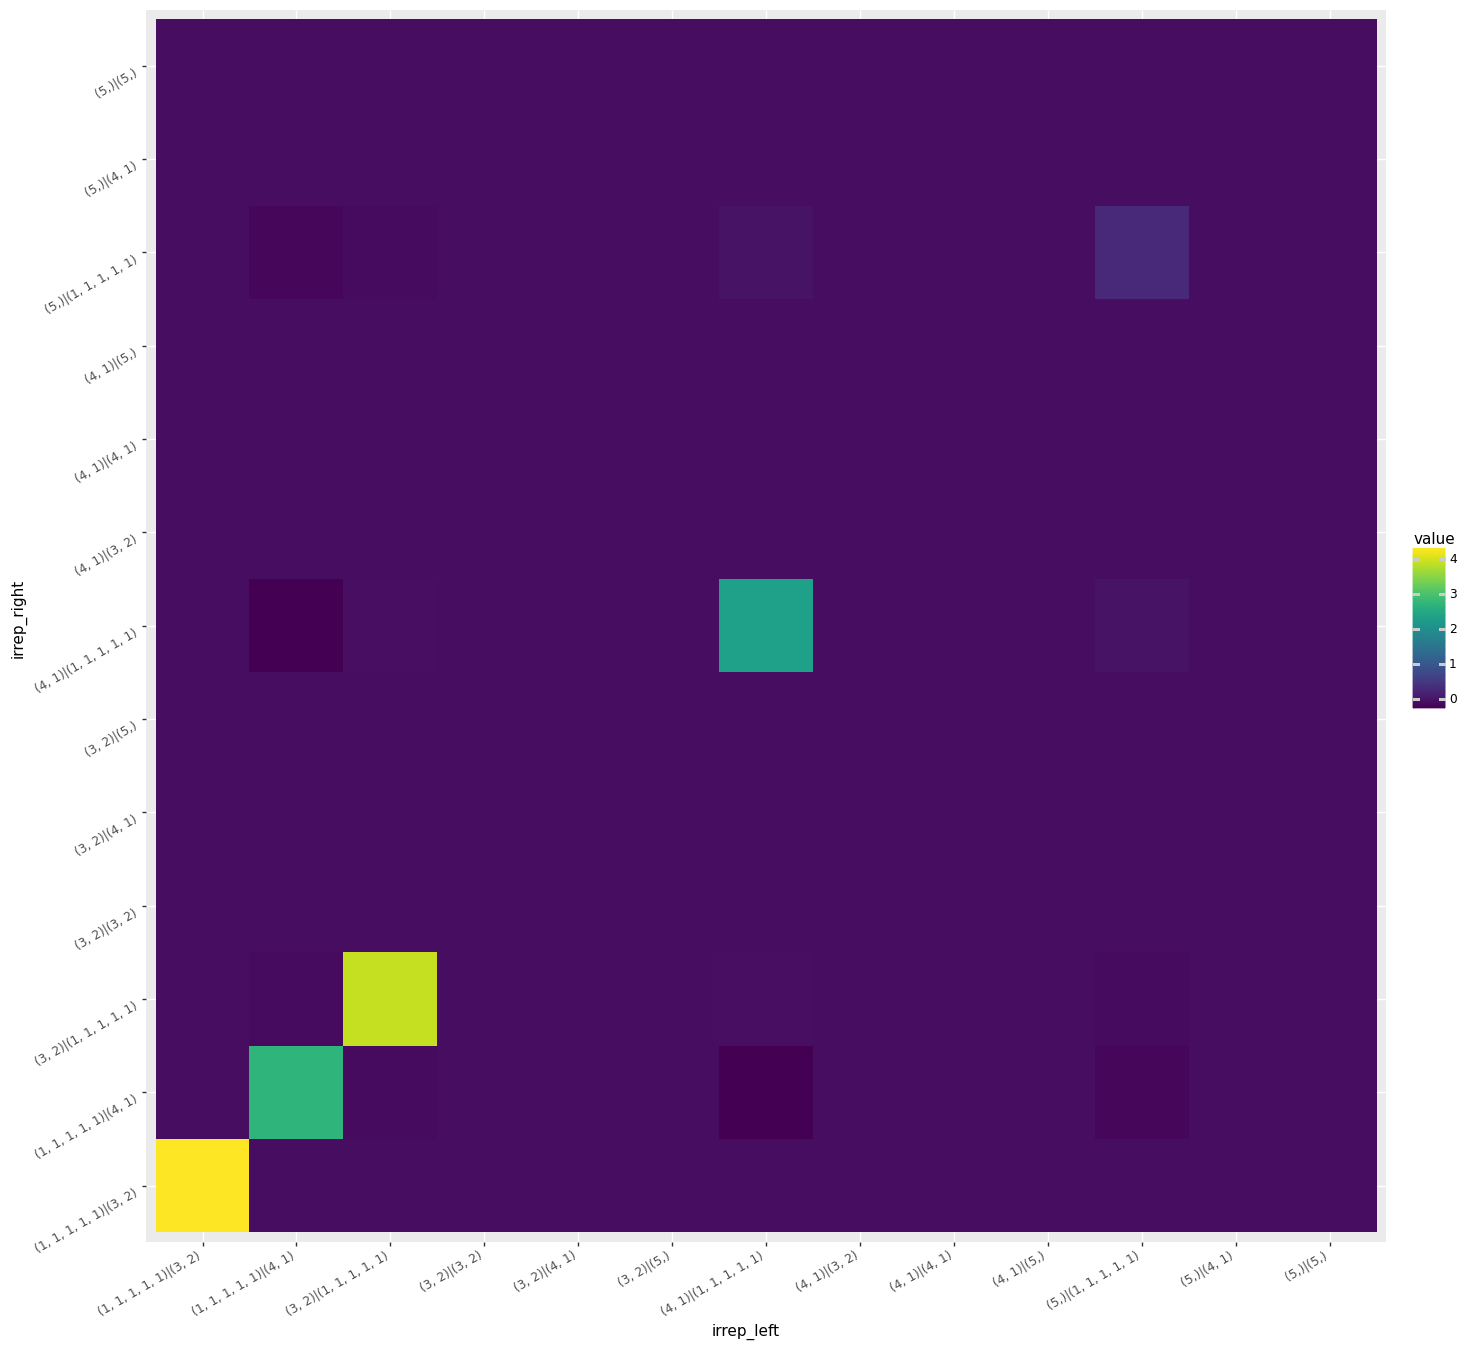

<ggplot: (740926630)>

In [98]:
import pandas as pd


import functorch

batch_cov = functorch.vmap(torch.cov, in_dims=(0,))


irreps = [
    "(3, 2)|(3, 2)",
    "(4, 1)|(4, 1)",
    "(4, 1)|(3, 2)",
    "(3, 2)|(4, 1)",
    "(4, 1)|(5,)",
    "(5,)|(4, 1)",
    "(3, 2)|(1, 1, 1, 1, 1)",
    "(1, 1, 1, 1, 1)|(3, 2)",
    "(4, 1)|(1, 1, 1, 1, 1)",
    "(1, 1, 1, 1, 1)|(4, 1)",
    "(5,)|(5,)",
    "(5,)|(1, 1, 1, 1, 1)",
    "(1, 1, 1, 1, 1)|(5,)"
    "(5,)|((3, 2)",
    "(3, 2)|(5,)"
]

cov_df = pl.DataFrame(torch.cov(linear_ft_decomp[1009]).numpy(), schema=partition_pairs)
cov_df.insert_at_idx(0, pl.Series('irrep_left', partition_pairs))
df = cov_df.melt(id_vars='irrep_left', variable_name='irrep_right').filter(
    pl.col('irrep_left').is_in(irreps) & pl.col('irrep_right').is_in(irreps)

)

(ggplot(df, aes(x='irrep_left', y='irrep_right', fill='value')) 
    + geom_tile()
    + theme(
        axis_text_x=element_text(rotation=30, hjust=1),
        axis_text_y=element_text(rotation=30, vjust=1),
        figure_size=(16, 16))
)

In [100]:
all_covs = batch_cov(linear_ft_decomp)


def get_cov_df(covariances):
    data = []
    for i, cov in enumerate(covariances):
        assert cov.shape == (49, 49)
        cov_df = pl.DataFrame(torch.cov(linear_ft_decomp[532]).numpy(), schema=partition_pairs)
        cov_df.insert_at_idx(0, pl.Series('irrep_left', partition_pairs))
        cov_df = cov_df.melt(id_vars='irrep_left', variable_name='irrep_right')
        cov_df.insert_at_idx(0, pl.Series('index', [i]*cov_df.shape[0]))
        data.append(cov_df)
    return pl.concat(data, how='vertical')
    
cov_data = get_cov_df(all_covs)

In [ ]:
(ggplot(cov_data.filter(pl.col('irrep_left').is_in(irreps) & pl.col('irrep_right').is_in(irreps)),
        aes(x='value')) + geom_histogram() + facet_wrap('~irrep_left+irrep_right')
)

/Users/dashiell/workspace/sn-grok/.venv/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 189719223620'. Pick better value with 'binwidth'.


In [73]:
cov_df = pl.DataFrame(torch.cov(linear_ft_decomp[532]).numpy(), schema=partition_pairs)
cov_df.insert_at_idx(0, pl.Series('irrep_left', partition_pairs))



irrep_left,irrep_right,value
str,str,f64
"""(4, 1)|(1, 1, ...","""(1, 1, 1, 1, 1...",-0.250157
"""(1, 1, 1, 1, 1...","""(4, 1)|(1, 1, ...",-0.250157


In [87]:
cov532 = torch.cov(linear_ft_decomp[532])
torch.take(cov532, ).shape

torch.Size([2, 1176])

tensor([ 4.1488e-05,  4.1488e-05,  4.1488e-05,  ..., -3.8292e-12,
        -2.4677e-10, -3.8292e-12], dtype=torch.float64)

In [97]:
cov532[torch.triu_indices(49, 49, 1)]

torch.Size([2, 1176, 49])